Using the old model prior to meeting to verify the recreation of the results.

In [97]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import matplotlib.pyplot as plt
import qutip

import system.experimental_august as system
importlib.reload(system)
import utils.solver as solver
importlib.reload(solver)
import pulse.tukey as pulse_gen
importlib.reload(pulse_gen)
import utils.expectation_values as expect
importlib.reload(expect)

pass

7.65683489745684
3.76364


Text(0, -55, 'Flat top pulse, ramp coefficient of 0.2')

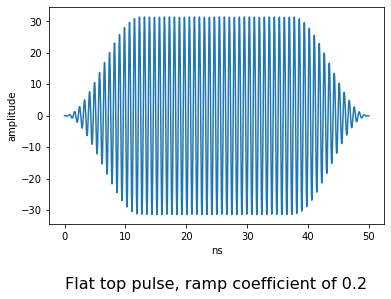

In [98]:
offset = 0.2257142857142857
drive_frequency = (system.first_energy_spacing/3 - offset)
tlist = np.linspace(0, 50, 2000)
print(drive_frequency)
print(system.first_energy_spacing/ (2*np.pi))
pulse_gen.setup(amplitude=5*2*np.pi, drive_frequency= drive_frequency, ramp_coef=0.5, tlist=tlist)
plt.plot(tlist, pulse_gen.get_pulse(tlist))
plt.xlabel("ns")
plt.ylabel("amplitude")
plt.text(0, -55, r'Flat top pulse, ramp coefficient of 0.2', fontsize=16)

In [99]:
# tlist = np.linspace(0, 1000, 1000*10)
# solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=True)

pulse_gen.setup(amplitude=2.5 * 2 * np.pi, drive_frequency= system.first_energy_spacing/3 - 0.20061224489795917, ramp_coef=0.2, tlist=tlist)
solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=(system.basis_states[0]), pbar=False)
expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)


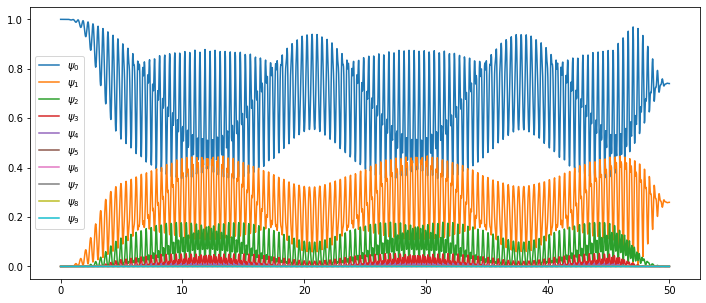

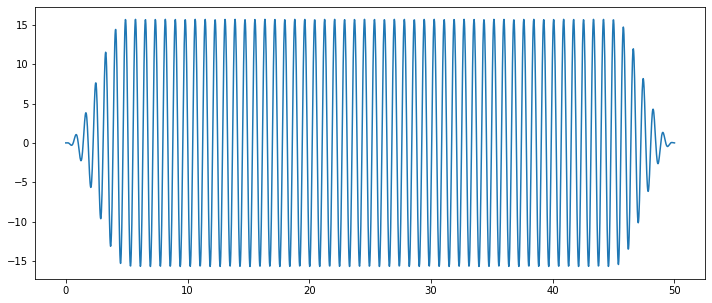

In [100]:
expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
fig, ax = plt.subplots(figsize=(12, 5))
for i in range(0, len(expectation_values)):
    ax.plot(tlist, expectation_values[i], label="$\psi_{%i}$" % i)
plt.legend()
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tlist, pulse_gen.get_pulse(tlist))

In [101]:
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor
all_results = []
_amp = 2.5*2*np.pi
_off = 0
_dur = 50

In [96]:
system.first_energy_spacing/(2*np.pi)

4.1787

# Vary Offset

In [104]:
def vary_offset(off):
    tlist = np.linspace(0, _dur, int(_dur*5))
    pulse_gen.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - off, ramp_coef=0.2, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": off,
        "frequency":  system.first_energy_spacing/3 - off,
        "duration": _dur,
        "amplitude": _amp
    }

offs_to_test = np.linspace(-1, 1, 50)
offset_varying_results = parfor(vary_offset, offs_to_test)

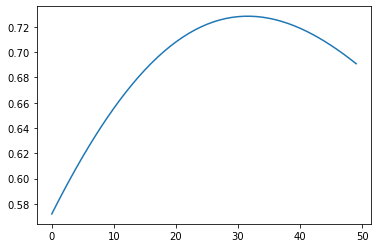

In [106]:
_fids_off_sweep = []
for result in offset_varying_results:
    _fids_off_sweep.append(result["fidelity"])

plt.plot(_fids_off_sweep)
plt.show()
best_offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
offs_to_test = np.linspace(best_offset-0.01, best_offset+0.01, 50)
offset_varying_results = parfor(vary_offset, offs_to_test)

In [107]:
offset_varying_results[np.argmax(_fids_off_sweep)]

{'fidelity': 0.7199043250121409,
 'offset': 0.27142857142857124,
 'frequency': 7.611120611742555,
 'duration': 50,
 'amplitude': 15.707963267948966}

## Gradient Descent (or at least Simplex)

In [108]:
import scipy

def cost(parameters, constants):
    # parameters = [offset, duration]
    offset = parameters[0]
    duration = parameters[1]
    # constants = [amplitude]
    amplitude = constants[0]
    tlist = np.linspace(0, duration, int(duration*10))
    pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=0.2, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    fidelity = expectation_values[1][-1]
    return (1-fidelity)

In [109]:
result1 = scipy.optimize.minimize(cost, [0.27142857142857124, 50], [2.5*2*np.pi], method="Nelder-Mead", options={"disp":True})

Optimization terminated successfully.
         Current function value: 0.003329
         Iterations: 40
         Function evaluations: 80


In [110]:
result1

 final_simplex: (array([[ 0.29941453, 60.85360683],
       [ 0.29941519, 60.85369372],
       [ 0.29941445, 60.85369278]]), array([0.00332921, 0.00332922, 0.00332922]))
           fun: 0.0033292136709476283
       message: 'Optimization terminated successfully.'
          nfev: 80
           nit: 40
        status: 0
       success: True
             x: array([ 0.29941453, 60.85360683])

# Fidelity Landscape

In [115]:
all_results = []

In [116]:
def run_once(dur):
    tlist = np.linspace(0, dur, int(dur*2))
    pulse_gen.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - _off, ramp_coef=0.5, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": _off,
        "frequency":  system.first_energy_spacing/3 - off,
        "duration": dur,
        "amplitude": _amp
    }

from tqdm import tqdm as tqdm
for off in tqdm(np.linspace(0.2, 0.4, 50)):
    _off = off
    already_did_this_offset = False
    for grouping in all_results:
        for result in grouping:
            if result["offset"] == _off:
                already_did_this_offset = True
                break
    if already_did_this_offset:
        continue

    all_results.append(parallel_map(run_once, np.linspace(1, 300, 50))) # , progress_bar=True

100%|██████████| 50/50 [19:23<00:00, 23.27s/it]


In [86]:
import utils.saver as saver

# saver.save(all_results, "temp_experimental_landscape")
# all_results = saver.load("temp_experimental_landscape")

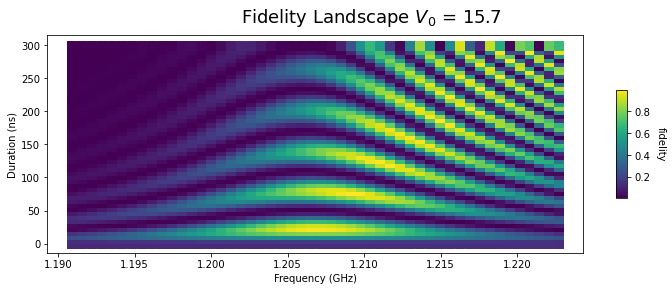

In [122]:
import copy
# %matplotlib widget

amps = []
offs = []
durs = []
fids = []
all_results_to_graph = copy.deepcopy(all_results)
for grouping in all_results_to_graph:
    for result in grouping:
        amps.append(result["amplitude"])
        offs.append(result["offset"])
        durs.append(result["duration"])
        fids.append(result["fidelity"])

fig, axs = plt.subplots(figsize=(12, 4))
fig.suptitle("Fidelity Landscape $V_0$ = %.1f" % amps[-1], fontsize=18)
axs.set_xlabel("Frequency (GHz)")
axs.set_ylabel("Duration (ns)")
freqs = (system.first_energy_spacing/3 - np.array(offs)) / (2*np.pi)
surf = axs.scatter(freqs, durs, c=fids, cmap=None, marker="s", s=85)
cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.ax.set_ylabel("fidelity", rotation=270)
cbar.ax.get_yaxis().labelpad = 15
# axs.pcolormesh(offs, durs, fids)